# Hypothesis

In short, we hypothesize that augmentation consistency of images will fall into 3 categories:
1. **Seen-before** tree species: High Consistency
2. **Not Seen-before** tree species: Medium Consistency
3. **Not Seen-before & Dissimilar** tree species: Low Consistency
    1. We also test on non-tree images for this category

Below is a table summarizing the expected consistency of the datasets.

| Dataset                     | Trained On | Same Species | Same Plot | Expected Consistency Rank |
|-----------------------------|------------|--------------|-----------|---------------------------|
| Train                       | Yes        | Yes          | Yes       | 1                         |
| Validation                  | No         | Yes          | Yes       | 2                         |
| Test                        | No         | Yes          | Yes       | 2                         |
| Casuarina (Same Species)    | No         | Yes          | No        | 3                         |
| Casuarina (Similar Species) | No         | No           | No        | 4                         |
| Casuarina (Diff Species)    | No         | No           | No        | 5                         |
| Non-Trees                   | No         | No           | No        | 6                         |


# Preparing the data

These are the datasets we'll be using:
- Chestnut @ 18th December 2020 **Train**
- Chestnut @ 10th May 2021 (43m) **Validation**
- Chestnut @ 10th May 2021 (60m) **Test**
- Casuarina **(Same/Similar/Different)**

Let's start by loading only the train dataset, we'll circle back to the other datasets later.

In [1]:
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import kl_div
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset
from torchvision.transforms.v2 import Compose, RandomCrop, \
    RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomApply, \
    ToImage, ToDtype, Resize
from tqdm import tqdm

from frdc.load.preset import FRDCDatasetPreset as ds
from frdc.models.efficientnetb1 import EfficientNetB1MixMatchModule
from frdc.models.inceptionv3 import InceptionV3MixMatchModule


In [2]:
ds_train = ds.chestnut_20201218()
ds_casuarina = ds.casuarina_20220418_93deg()

To start, we'll construct a function to plot a grid of samples.

In [3]:
def plot_samples(samples: list[tuple[np.ndarray, str]],
                 title: str,
                 rows: int, ):
    """Plot a grid of samples with their targets."""
    fig, axs = plt.subplots(rows, ceil(len(samples) / rows),
                            figsize=(10, rows * 2))
    for (im_bgr, tgt), ax in zip(samples, axs.flatten()):
        im_rgb = np.nan_to_num(im_bgr[..., [2, 1, 0]]).astype(int)
        ax.imshow(im_rgb)
        ax.set_title(f"{tgt}")
        ax.axis("off")
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

Let's plot some samples from the train dataset.

> We use a `zip` to limit the number of samples to the number of rows.
> This works by prematurely stopping the iteration when `range(n_samples)` is exhausted.
> This will thus also stop the `ds_train` iteration.

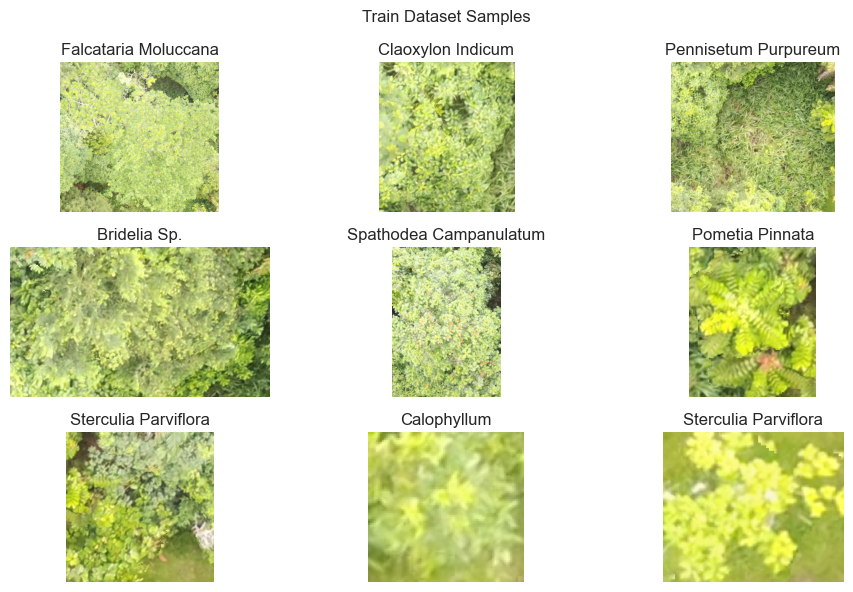

In [4]:
n_samples = 9
plot_samples(
    [(im, tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train)],
    "Train Dataset Samples",
    rows=3,
)

Recall that for Label Studio, the trees are cropped via a polygon.
However, to simplify things, we will use the full smallest bounding box that contains the polygon.

We kind of get the idea of Chestnut Nature Park trees, let's skip to the Casuarina dataset.

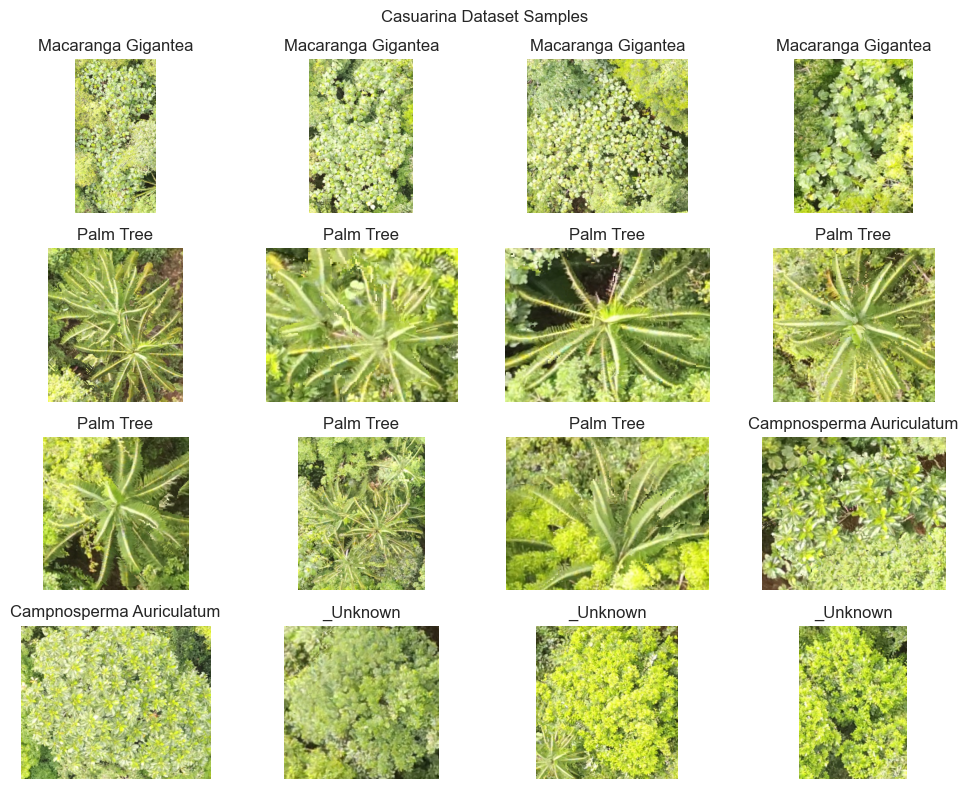

In [5]:
n_samples = 16
plot_samples(
    [(im, tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_casuarina)],
    "Casuarina Dataset Samples",
    rows=4,
)

As observed, we do have a separate plethora of tree species in the Casuarina dataset.
The key is that the model has also seen **Campnosperma Auriculatum**,
however, never seen **Macaranga Gigantea** nor **Palm Tree**.
Furthermore, we have some other trees unlabeled.

By eye, we see that **Macaranga**, despite not seen before, is similar to trees in the Chestnut dataset.
While **Palm Tree** is not similar to any trees in the Chestnut dataset.

That said, we can expect the following consistency:

| Tree Species             | Expected Consistency Rank |
|--------------------------|---------------------------|
| Campnosperma Auriculatum | 1                         |
| Macaranga Gigantea       | 2                         |
| Palm Tree                | 3                         |
 

# Model

Before we proceed, let's load the model we used for training.

This model is
- trained only on the Chestnut 18th December 2020 dataset
- validated on the Chestnut 10th May 2021 (43m) dataset
- tested on the Chestnut 10th May 2021 (60m) dataset
- never seen the Casuarina dataset

In [6]:
m: EfficientNetB1MixMatchModule = EfficientNetB1MixMatchModule.load_from_checkpoint(
    "efficientb1_model.ckpt").eval()

As a recap, our adapted Model changes the following:
1. The first layer is changed to accept 8 channels
2. The last layer is replaced to output K classes

In [7]:
print("Adapted First Layer")
print(m.eff.features[0])
print("\nAdapted Last Layer")
print(m.fc)

Adapted First Layer
Conv2dNormActivation(
  (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

Adapted Last Layer
Sequential(
  (0): Linear(in_features=1280, out_features=19, bias=True)
  (1): Softmax(dim=1)
)


# Evaluating Consistency

To evaluate the consistency, we need to define a function that:
1. Takes in a dataset
2. For each image, it will:
    1. Augment the image `n` times
    2. Pass the augmented images through the model
    3. Compute the consistency of the predictions
3. Return the consistency of the dataset

Firstly, let's define the augmentation function.

## Augmentation

> The augment is the same as the one used for training.

This augmentation is quite simple, a random crop, flips and rotations.
Generally, these augmentations are considered **weak**, as they generate samples very likely to have been taken instead.  

In [8]:
def augmentation(x):
    return Compose(
        [
            ToImage(),
            ToDtype(torch.float32),
            Resize(
                InceptionV3MixMatchModule.MIN_SIZE,
                antialias=False,
            ),
            RandomCrop(
                InceptionV3MixMatchModule.MIN_SIZE,
                pad_if_needed=False,
            ),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomApply([RandomRotation((90, 90))], p=0.5),
        ]
    )(x)


As mentioned above, we only loaded the train dataset. This is because we will now apply the augmentations

In [9]:
ds_train_aug = ds.chestnut_20201218(transform=augmentation)

## Looping through the dataset

We will loop through the dataset, which has our augmentation function applied.

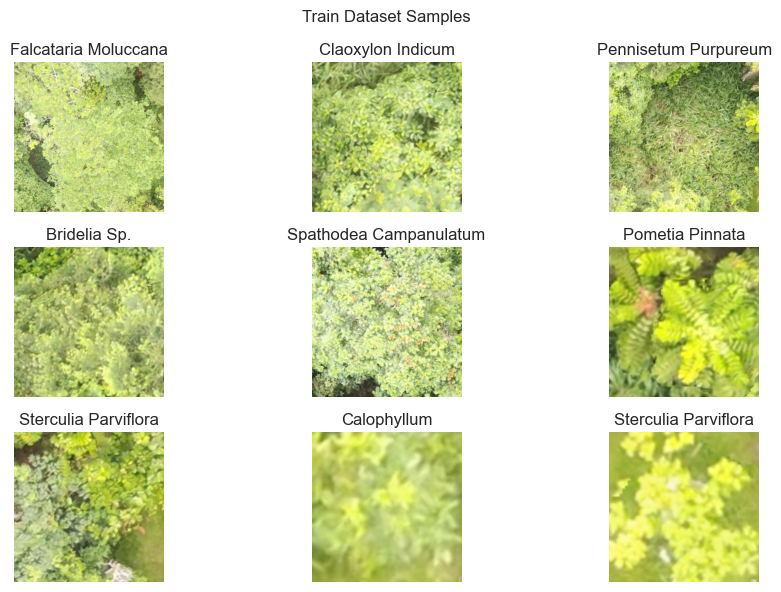

In [10]:
n_samples = 9
plot_samples(
    [(im.permute(1, 2, 0), tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train_aug)],
    "Train Dataset Samples",
    rows=3,
)

As a quick check, we re-run the augmentation function to see if the images augmented randomly 

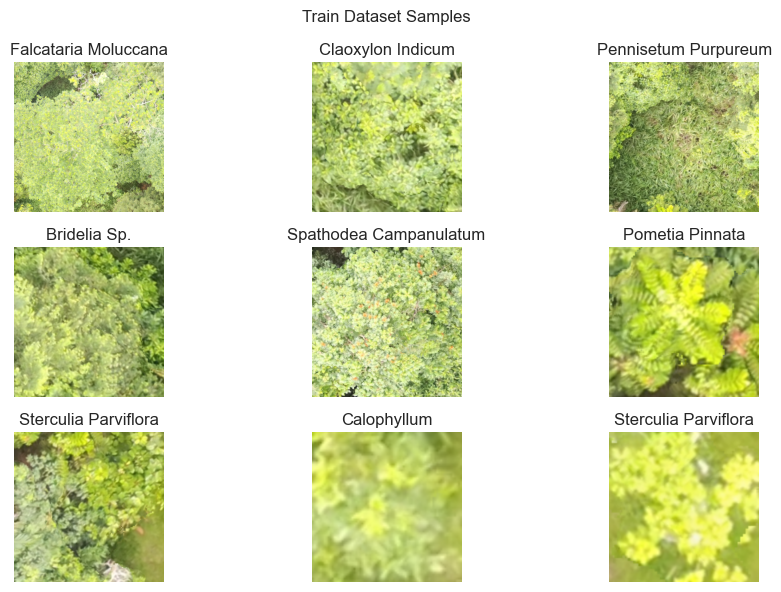

In [11]:
plot_samples(
    [(im.permute(1, 2, 0), tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train_aug)],
    "Train Dataset Samples",
    rows=3,
)

Before we jump into "Consistency", we'd have to understand a simple concept about it.

Consistency is the measurement of how robust the model is against any perturbations in the input.
This is because, in real life, while the object may be the same, the image captured will never be
consistent. This is due to lighting, angle, and other factors. This shift in the captured input is
also known as "Domain Shift". It's important to note that the model should **still** reproduce the same
output, regardless this shift.

To illustrate what is a "pertubation", observe the following example:
1. We have a picture of a tree
2. Then, we compare it against it, but it's flipped horizontally 

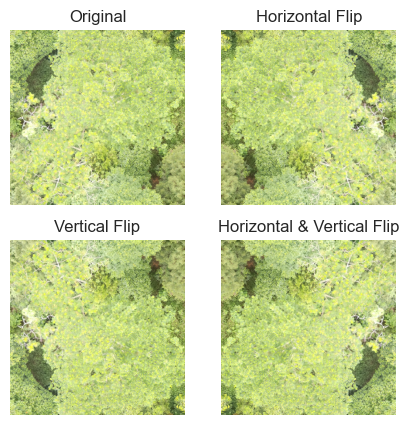

In [12]:
x, y = next(iter(ds_train_aug))
x_hf = x.flip(2)
x_vf = x.flip(1)
x_hvf = x.flip(1).flip(2)
y_ix = m.y_encoder.transform([[y]])[0]


def plot(x, ax, title):
    ax.imshow(x.permute(1, 2, 0).numpy()[..., [2, 1, 0]].astype(int))
    ax.set_title(title)
    ax.axis("off")


fig, ax = plt.subplots(2, 2, figsize=(5, 5))
ax = ax.flatten()
plot(x, ax[0], "Original")
plot(x_hf, ax[1], "Horizontal Flip")
plot(x_vf, ax[2], "Vertical Flip")
plot(x_hvf, ax[3], "Horizontal & Vertical Flip")

Despite the flips, the model should ultimately produce the same output.

We need some custom preprocessing (scaling) to match the model's input.

In [13]:
def x_preprocess(x):
    b, c, h, w = x.shape
    x_ss = m.x_scaler.transform(
        x.permute(0, 2, 3, 1).reshape(-1, c)
    )
    return torch.nan_to_num(
        torch.from_numpy(x_ss.reshape(b, h, w, c))
        .permute(0, 3, 1, 2)
        .float()
    )

Let's evaluate the flips and see if the model is consistent.

In [14]:
def predict(x):
    return m(x_preprocess(x.unsqueeze(0)).cuda()).detach().cpu().squeeze()


y = predict(x)
y_hf = predict(x_hf)
y_vf = predict(x_vf)
y_hvf = predict(x_hvf)

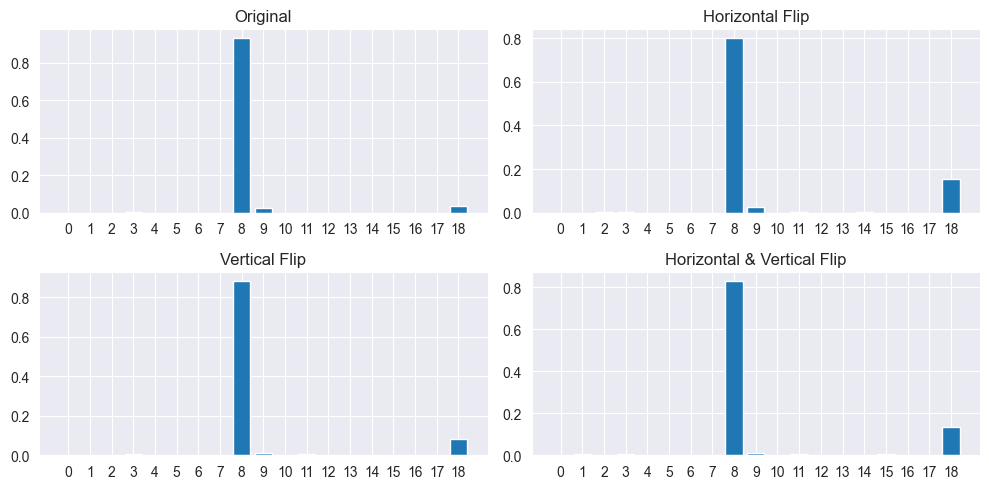

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()


def plot_pred(y, ax, title):
    ax.bar(range(len(y)), y)
    ax.set_title(title)
    ax.set_xticks(range(len(y)))


plot_pred(y, ax[0], "Original")
plot_pred(y_hf, ax[1], "Horizontal Flip")
plot_pred(y_vf, ax[2], "Vertical Flip")
plot_pred(y_hvf, ax[3], "Horizontal & Vertical Flip")
plt.tight_layout()

As observed, the predictions are consistent across the flips, which is excellent.
Note that consistency is not only able the majority class, but also the distribution of the predictions. 

To measure this consistency, we can utilize the Jensen-Shannon Divergence (JSD).
JSD is an extension of the Kullback-Leibler Divergence (KL Divergence), which measures the similarity between two probability distributions. The unique property of JSD is that it's symmetric, and it's always between 0 and 1, which makes it easier to interpret.

$$
JSD(P, Q) = \frac{1}{2} D_{KL}(P || M) + \frac{1}{2} D_{KL}(Q || M)
$$

Where $M = \frac{1}{2} (P + Q)$
M is also known as the "Mixture Distribution".

It's also possible to extend this to multiple probability distributions.
In this case M will be the mean of the distributions.
$$
JSD(P_1, P_2, \ldots, P_n) = \frac{1}{n} \sum_{i=1}^{n} D_{KL}(P_i || M)
$$

> We can also consider weighing each distribution, however, it's not necessary for this case.

JSD Shape: torch.Size([19]) (Classes)
Scalar JSD: 0.021531030535697937


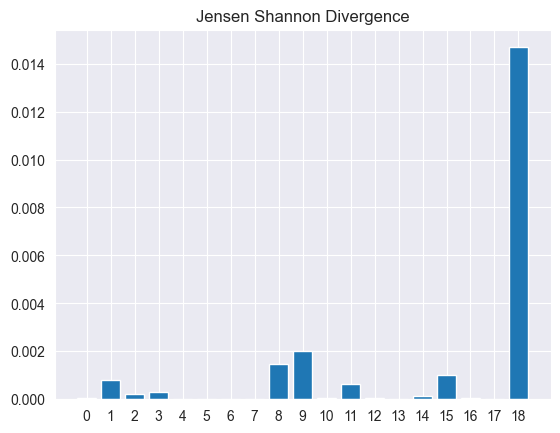

In [16]:
y_mix = (y + y_hf + y_vf + y_hvf) / 4
jsd = torch.stack([
    kl_div(torch.log(y), y_mix),
    kl_div(torch.log(y_hf), y_mix),
    kl_div(torch.log(y_vf), y_mix),
    kl_div(torch.log(y_hvf), y_mix),
]).mean(dim=0)
print(f"JSD Shape: {jsd.shape} (Classes)")

fig, ax = plt.subplots()
plot_pred(jsd, ax, "Jensen Shannon Divergence")
print(f"Scalar JSD: {jsd.sum()}")

As shown, the JSD measures the variation of the predictions, for each class. 
We can get the scalar JSD by its sum.

Now, let's consider what happens if we use an image of non-trees.

> We intentionally found an image that doesn't have any greens. This is also the 8th airplane image in CIFAR10.

In [17]:
# load the image ood.jpg as a tensor
from PIL import Image

ood = Image.open("ood.jpg")
ood = ood.resize((299, 299))
ood = torch.tensor(np.array(ood)).permute(2, 0, 1).float()

ood = ood / 255
ood = torch.cat([ood, ood[1:2].repeat(5, 1, 1)], dim=0)

# This rescale the image such that it's in the same range as the one we sampled above.
# Firstly get the bounds of the image we sampled above
x_min = x.reshape(x.shape[0], -1).min(dim=1).values.reshape(-1, 1, 1)
x_max = x.reshape(x.shape[0], -1).max(dim=1).values.reshape(-1, 1, 1)

# get the bounds of this ood image
ood_min = ood.reshape(ood.shape[0], -1).min(dim=1).values.reshape(-1, 1, 1)
ood_max = ood.reshape(ood.shape[0], -1).max(dim=1).values.reshape(-1, 1, 1)

# This firstly 0-1 scales the image independently, each channel
ood = (ood - ood_min) / (ood_max - ood_min)
# Then, it scales the image to the same range as the chestnut dataset
ood = ood * (x_max - x_min) + x_min

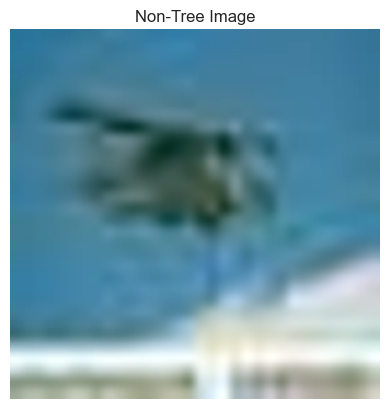

In [18]:
plt.imshow(ood.squeeze().permute(1, 2, 0).numpy()[..., :3].astype(int))
plt.title("Non-Tree Image")
_ = plt.axis("off")

Same as before, we'll evaluate the consistency of the predictions.

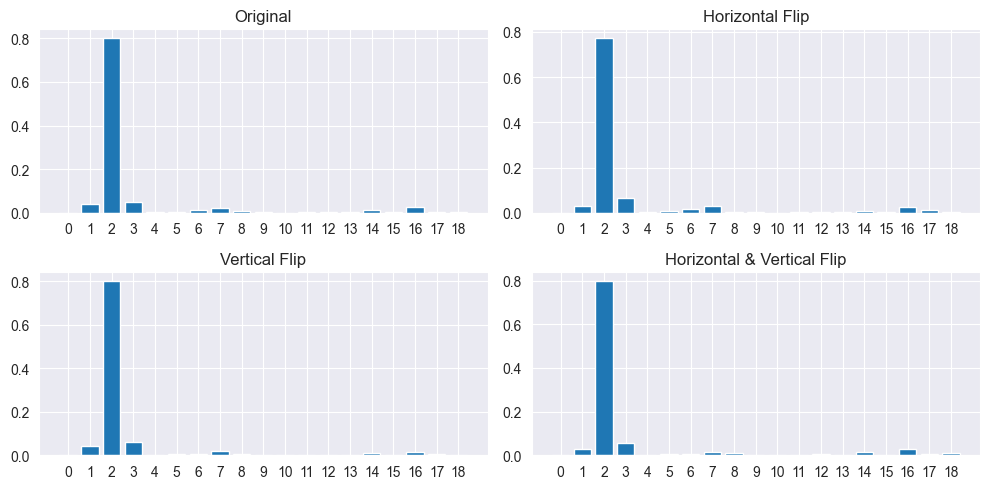

In [19]:
y_ood = predict(ood)
y_ood_hf = predict(ood.flip(2))
y_ood_vf = predict(ood.flip(1))
y_ood_hvf = predict(ood.flip(1).flip(2))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
plot_pred(y_ood, ax[0], "Original")
plot_pred(y_ood_hf, ax[1], "Horizontal Flip")
plot_pred(y_ood_vf, ax[2], "Vertical Flip")
plot_pred(y_ood_hvf, ax[3], "Horizontal & Vertical Flip")
plt.tight_layout()


Surprisingly, the results are consistent, despite the image being a non-tree.
Let's calculate the JSD.

JSD Shape: torch.Size([19]) (Classes)
Scalar JSD: 0.005693243350833654


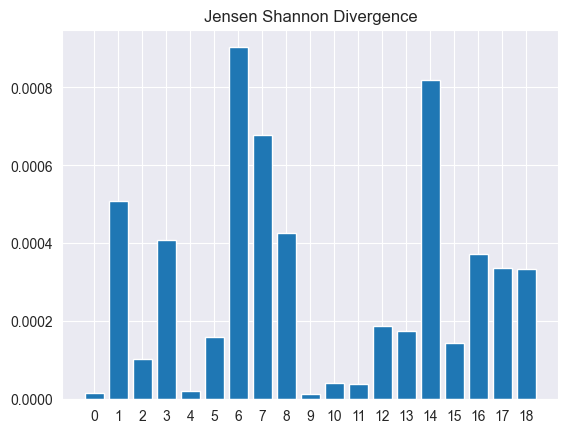

In [20]:
y_ood_mix = (y_ood + y_ood_hf + y_ood_vf + y_ood_hvf) / 4
jsd_ood = torch.stack([
    kl_div(torch.log(y_ood), y_ood_mix),
    kl_div(torch.log(y_ood_hf), y_ood_mix),
    kl_div(torch.log(y_ood_vf), y_ood_mix),
    kl_div(torch.log(y_ood_hvf), y_ood_mix),
]).mean(dim=0)
print(f"JSD Shape: {jsd_ood.shape} (Classes)")
fig, ax = plt.subplots()
plot_pred(jsd_ood, ax, "Jensen Shannon Divergence")
print(f"Scalar JSD: {jsd_ood.sum()}")

Again, the JSD is consistent, and it's quite low, much lower than the tree above.

This result is not necessarily surprising, we'll explain why later.

Before, that, we'll perform this on the entire dataset.

Here, we loop through the dataset repeatedly, and store the predictions.
These will be then used to calculate the Jensen-Shannon Divergence.

In [21]:
y_preds = []
y_tgt = []
iterations = 20
for i in tqdm(range(iterations), desc="Iterations"):
    y_batch_pred = m(x_preprocess(
        torch.stack([im for im, tgt in ds_train_aug])).cuda()).detach().cpu()
    y_preds.append(y_batch_pred)

y_tgt = [tgt for im, tgt in ds_train_aug]
y_pred = torch.stack(y_preds)

Iterations: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Getting the Mixture Distribution is quite simple.

1) We prepare `js_p` to have the sample dimension in-front (i.e. each sample is a row), so we can iterate through it easily later.
2) We calculate the mean of the predictions across the iterations, which is the mixture distribution.

In [22]:
js_p = y_pred.permute(1, 0, 2)
js_q = y_pred.mean(dim=0)
print(js_p.shape, js_q.shape)

torch.Size([32, 20, 19]) torch.Size([32, 19])


The above shapes:
- `js_p` is $(\text{Samples}, \text{Iterations}, \text{Classes})$
- `js_q` is $(\text{Samples}, \text{Classes})$

*To keep it simple, we'll avoid trying to vectorize the computation.*

Now, we calculate the Jensen-Shannon Divergence.

1) We iterate through the samples, `js_p_i` is the predictions for the $i$-th sample.
2) We calculate the KL Divergence between the $i$-th sample and the mixture distribution.
3) `jsd` is the Jensen-Shannon Divergence for each sample. Note that the Divergence is a vector, not a scalar. This is because each distribution is compared against the mixture distribution. Therefore `jsd` is of shape $\text{Samples} \times \text{Iterations}$.
4) We then sort the JSD for better visualization. (This is because iteration order doesn't matter)

In [23]:
jsd = []
for js_p_i, js_q_i in zip(js_p, js_q):
    jsd_i = (
        torch
        .stack([kl_div(torch.log(d), js_q_i) for d in js_p_i])
        .mean(dim=1)
    )
    jsd.append(jsd_i)

jsd = torch.stack(jsd).detach().numpy()

df_jsd = pd.DataFrame(jsd, index=y_tgt)
# Sorted JSD
df_jsd[:] = np.sort(df_jsd.values, axis=1)[:, ::-1]

At this point, `jsd` is actually a matrix of $\text{Samples} \times \text{Iterations}$.
We can visualize this as a heatmap.

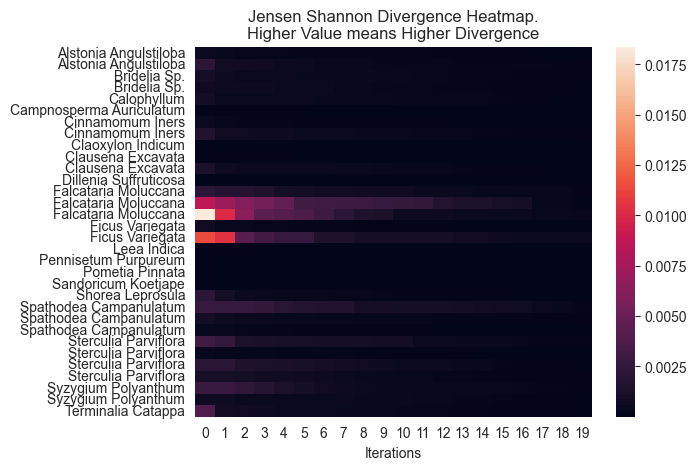

In [24]:
ax = sns.heatmap(df_jsd.sort_index(), yticklabels=True)
ax.set_title(
    "Jensen Shannon Divergence Heatmap.\nHigher Value means Higher Divergence")
_ = ax.set_xlabel("Iterations")

We can see the spread of the divergence with the heatmap.

# Results

Now, we'll wrap the above into a function and apply it to the other datasets.

> We also get the Cross Entropy as a means of measuring accuracy.

In [25]:
def get_jsd(m, ds, iterations=200, calculate_ce: bool = False) -> tuple[
    pd.DataFrame, pd.DataFrame | None
]:
    y_pred = []
    for _ in tqdm(range(iterations), desc="Iterations"):
        y_batch_pred = m(x_preprocess(
            torch.stack([im for im, tgt in ds])).cuda()).detach().cpu()
        y_pred.append(y_batch_pred)

    y_tgt = [tgt for im, tgt in ds]
    y_pred = torch.stack(y_pred)
    js_p = y_pred.permute(1, 0, 2)
    js_q = y_pred.mean(dim=0)
    jsd = []
    for js_p_i, js_q_i in zip(js_p, js_q):
        a = torch.stack(
            [kl_div(torch.log(d + 1e-10), js_q_i) for d in js_p_i]).mean(
            dim=1)
        jsd.append(a)

    jsd = torch.stack(jsd).detach().numpy()
    df_jsd = pd.DataFrame(jsd, index=y_tgt)
    df_jsd_median_order = df_jsd.median(axis=1).argsort()
    df_jsd = df_jsd.iloc[df_jsd_median_order]
    df_ce = None
    if calculate_ce:
        # This is unfortunately quite verbose
        y_tgt_enc = torch.tensor(
            m.y_encoder.transform(
                np.array(y_tgt).reshape(-1, 1)
            ).squeeze()
        )
        y_pred_mean = y_pred.mean(dim=0)

        # Some targets are never seen by the y_encoder, they will be NaN
        # As a hacky way to get around this, we just set them to the first target.
        y_tgt_enc = torch.nan_to_num(y_tgt_enc, nan=0).long()

        # By default, the reduction is "mean", we want "none" to get the per-sample CE
        y_ce = cross_entropy(y_pred_mean, y_tgt_enc, reduction="none")

        df_ce = pd.DataFrame(y_ce.detach().numpy(), index=y_tgt)
        df_ce = df_ce.iloc[df_jsd_median_order]

    return df_jsd, df_ce

We also construct some handy plotting functions.

In [26]:
def plot_jsd_heatmap(df: pd.DataFrame, figsize=(3, 5)):
    # This sorts the rows (iterations) independently
    df[:] = np.sort(df.values, axis=1)[..., ::-1]

    # seaborn somehow reverses the y-axis, so we reverse the dataframe
    ax = sns.heatmap(df[::-1], yticklabels=True, vmin=0,
                     xticklabels=False)

    ax.set_title(
        "Jensen Shannon Divergence Heatmap.\nLower Value is better")
    ax.set_xlabel("Iterations")
    plt.gcf().set_size_inches(*figsize)
    plt.show()

In [27]:
def plot_jsd_median_hbar(df: pd.DataFrame, figsize=(3, 5)):
    df.median(axis=1).plot(kind="barh")

    plt.title(
        "Jensen Shannon Divergence Median.\nLower Value is better")
    # plt.xlim(*xlim)
    plt.gcf().set_size_inches(*figsize)
    plt.show()

In [28]:
def plot_ce_hbar(df: pd.DataFrame, figsize=(5, 5)):
    df.plot(kind="barh")

    plt.title(
        "Cross Entropy Median.\nLower Value is better")
    plt.legend().remove()
    plt.gcf().set_size_inches(*figsize)
    plt.tight_layout()
    plt.show()

## Train Dataset Results
We'll start by evaluating the train dataset.

In [29]:
df_train_jsd, df_train_ce = get_jsd(m, ds_train_aug, calculate_ce=True)

Iterations: 100%|██████████| 200/200 [00:57<00:00,  3.46it/s]


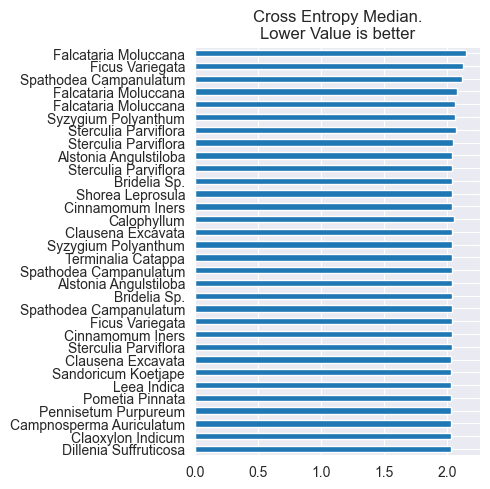

In [30]:
plot_ce_hbar(df_train_ce)

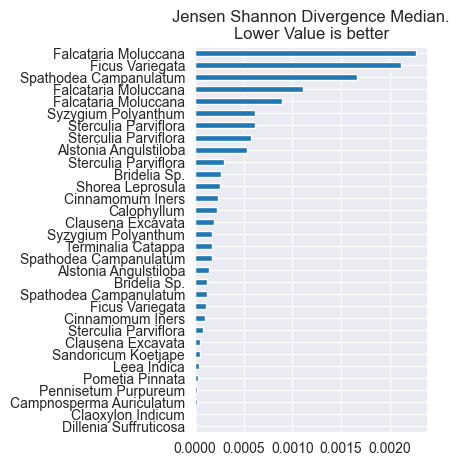

In [31]:
plot_jsd_median_hbar(df_train_jsd)

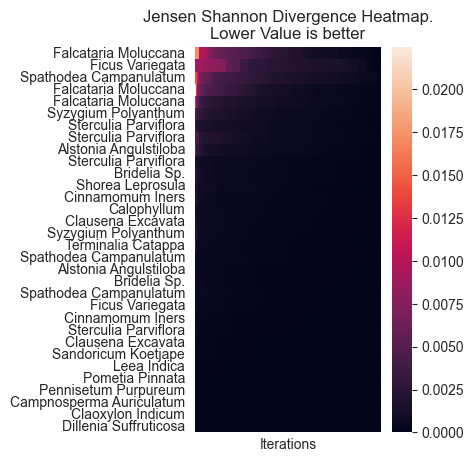

In [32]:
plot_jsd_heatmap(df_train_jsd)

### Train Dataset Discussion

We see that the Cross Entropy aligning with the Divergence makes sense, as lower divergence logically correlates with higher accuracy. However, this isn't all, as this is only the train dataset.

## Validation Dataset Results

In [33]:
ds_val_aug = ds.chestnut_20210510_43m(transform=augmentation)

In [34]:
df_val_jsd, df_val_ce = get_jsd(m, ds_val_aug, calculate_ce=True)

Iterations: 100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


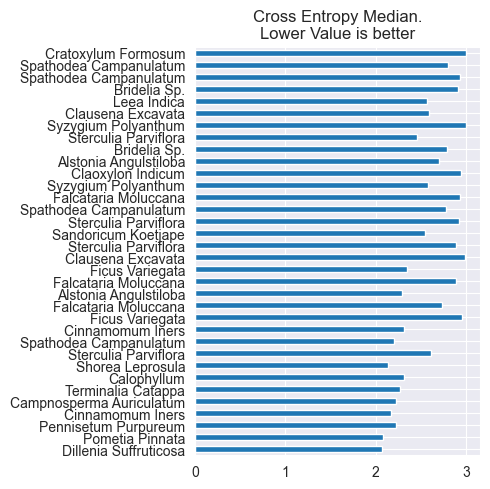

In [35]:
plot_ce_hbar(df_val_ce)

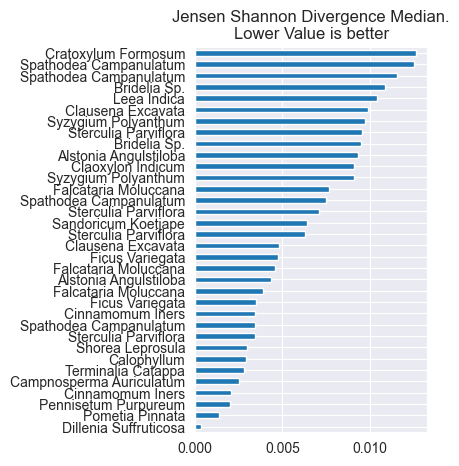

In [36]:
plot_jsd_median_hbar(df_val_jsd)

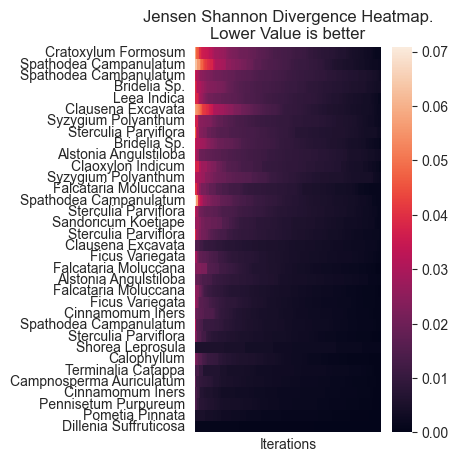

In [37]:
plot_jsd_heatmap(df_val_jsd)

### Validation Dataset Discussion

In a surprising turn of events, the divergence is actually lower than the train dataset.
This is quite unexpected, as the model has never seen the validation dataset, yet managed to 
perform better.

## Casuarina Dataset Results

This will be our "OOD" dataset. There are some species that are in-distribution, but most are not.

In [38]:
ds_casuarina_jsd = ds.casuarina_20220418_93deg(transform=augmentation)
df_casuarina_jsd, _ = get_jsd(m, ds_casuarina_jsd)

Iterations: 100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


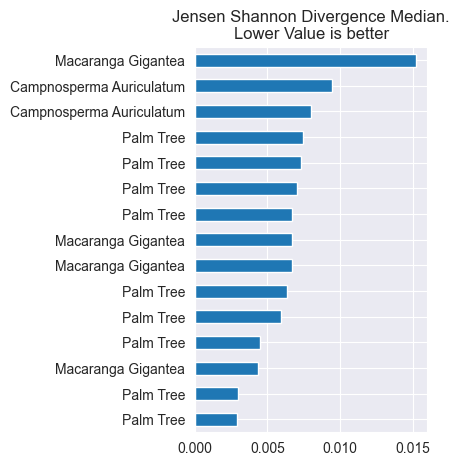

In [39]:
# Get all samples not "_Unknown"
plot_jsd_median_hbar(df_casuarina_jsd[df_casuarina_jsd.index != "_Unknown"])

C:\Users\CH0002HN\AppData\Local\Temp\ipykernel_41776\2531824620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.sort(df.values, axis=1)[..., ::-1]
C:\Users\CH0002HN\AppData\Local\Temp\ipykernel_41776\2531824620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.sort(df.values, axis=1)[..., ::-1]


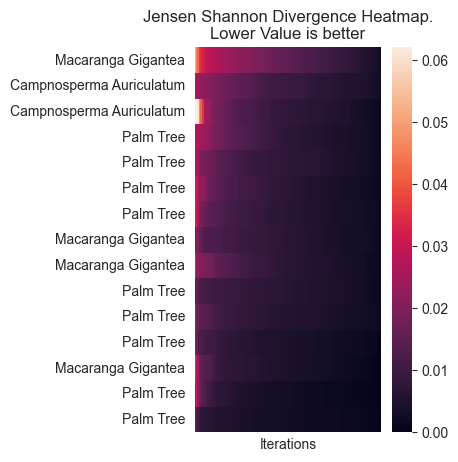

In [40]:
plot_jsd_heatmap(df_casuarina_jsd.loc[df_casuarina_jsd.index != "_Unknown"])

### Casuarina Dataset Discussion

Interestingly, again, it's not worse than the train dataset!

However, there's an interesting trend, Palm trees are the least divergent, followed by Campnosperma Auriculatum, and finally Macaranga Gigantea. While one would expect the opposite, this is quite interesting.

## Noise Dataset Results

Finally, we want to test it against a noise dataset.
However, note that the noise generated must be to scale with the images.
We'll check the minimum and maximum values the chestnut dataset and generate noise within that range.

In [41]:
chn_min = torch.tensor(
    [np.nanmin(ds_train.ar[..., c]) for c in
     range(ds_train.ar.shape[-1])]).reshape(8, 1, 1)
chn_max = torch.tensor(
    [np.nanmax(ds_train.ar[..., c]) for c in
     range(ds_train.ar.shape[-1])]).reshape(8, 1, 1)

We create a dataset that generates noise within the range of the chestnut dataset.
Note that `torch.rand` is a uniform distribution $[0,1]$, so we can just scale it. 

In [42]:
class NoiseDataset(Dataset):
    def __init__(self, size: int, transform=None):
        self.size = size
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise IndexError
        x = torch.rand(8, 500, 500) * (chn_max - chn_min) + chn_min
        if self.transform:
            x = self.transform(x)
        return x, 0


ds_noise = NoiseDataset(25, transform=augmentation)

In [43]:
df_noise_jsd, _ = get_jsd(m, ds_noise, iterations=100)

Iterations: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


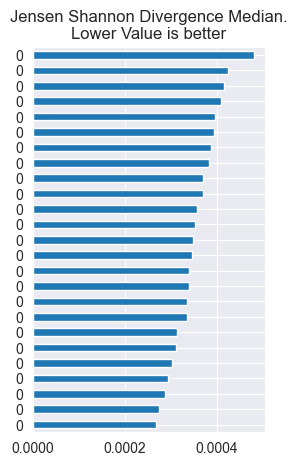

In [44]:
plot_jsd_median_hbar(df_noise_jsd)

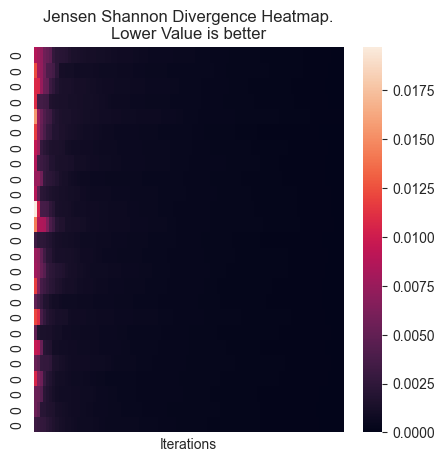

In [45]:
plot_jsd_heatmap(df_noise_jsd, figsize=(5, 5))

### Noise Dataset Discussion

Again, the phenomenon of the divergence being lower than the train dataset is observed.
This is quite interesting, as the noise dataset is not even a tree.

Maybe we are looking at consistency in the wrong way?

Let's take a look at the final test, which is using CIFAR10.

## Constant Dataset Results

In [46]:
class ConstDataset(Dataset):
    def __init__(self, size: int, transform=None):
        self.size = size
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise IndexError
        x = torch.ones(8, 500, 500) * (chn_max - chn_min) + chn_min
        if self.transform:
            x = self.transform(x)
        return x, 0


ds_const = ConstDataset(25, transform=augmentation)
df_const_jsd, _ = get_jsd(m, ds_const, iterations=100)

Iterations: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


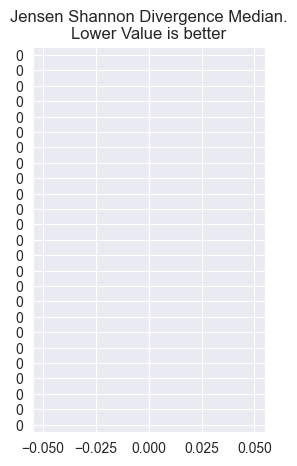

In [47]:
plot_jsd_median_hbar(df_const_jsd)

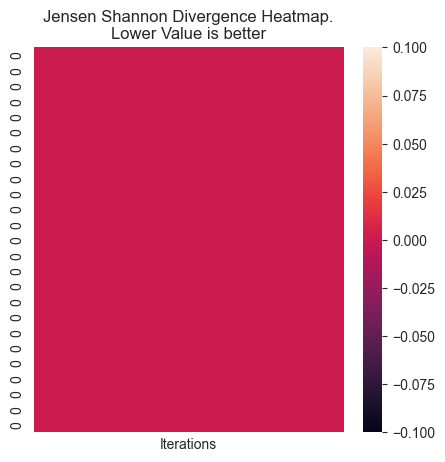

In [48]:
plot_jsd_heatmap(df_const_jsd, figsize=(5, 5))

### Constant Dataset Discussion

As expected, the divergence is the lowest, as the image is the same in every iteration.

## CIFAR10 Results

We'll use the CIFAR10 dataset, this is notably different from the chestnut dataset as it's
a dataset of everyday objects. We can consider this a dataset much more OOD than the Casuarina dataset.

In [49]:
from torchvision.datasets import CIFAR10
from PIL import Image


class CIFAR10Extended(CIFAR10):
    def __len__(self):
        return 100

    def __getitem__(self, index: int):
        if index >= 100:
            raise IndexError
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        # Repeat the green channel for 5 more times and append to the img
        img = np.concatenate(
            [np.array(img), np.repeat(np.array(img)[:, :, 1:2], 5, axis=2)],
            axis=2)

        # Scale by noise
        img = (img / 256) * (
                chn_max.numpy().reshape(1, 1, 8) - chn_min.numpy().reshape(
            1, 1, 8)) + chn_min.numpy().reshape(1, 1, 8)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [50]:
ds = CIFAR10Extended(root="data", download=False, transform=augmentation, )

In [51]:
df_cifar10_jsd, _ = get_jsd(m, ds)

Iterations: 100%|██████████| 200/200 [02:56<00:00,  1.14it/s]


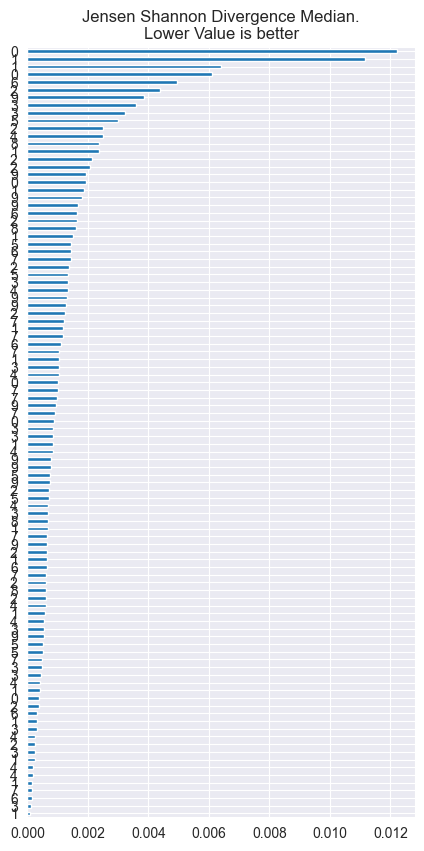

In [52]:
plot_jsd_median_hbar(df_cifar10_jsd, figsize=(5, 10))

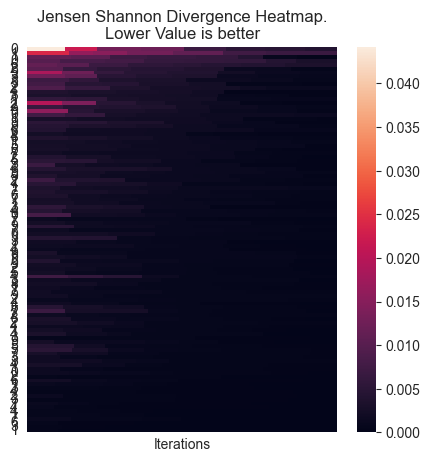

In [53]:
plot_jsd_heatmap(df_cifar10_jsd, figsize=(5, 5))

### CIFAR10 Dataset Discussion

Here's where it gets interesting, the divergence spread seems to be the same as the train dataset.
So, even though the dataset is OOD, the divergence is not as high as expected.

# Discussion

Our original hypothesis was that the consistency would be ranked as follows:


| Dataset                     | Trained On | Same Species | Same Plot | Expected Consistency Rank |
|-----------------------------|------------|--------------|-----------|---------------------------|
| Train                       | Yes        | Yes          | Yes       | 1                         |
| Validation                  | No         | Yes          | Yes       | 2                         |
| Test                        | No         | Yes          | Yes       | 2                         |
| Casuarina (Same Species)    | No         | Yes          | No        | 3                         |
| Casuarina (Similar Species) | No         | No           | No        | 4                         |
| Casuarina (Diff Species)    | No         | No           | No        | 5                         |
| Non-Trees                   | No         | No           | No        | 6                         |

However, that's not exactly true, we may not even have sufficient evident to rank consistencies.

One would try to tackle understanding these results, however, I believe there's a simpler explanation.

## Consistency is Heavily Dependent on the Augmentation

Recall that our augmentation is simply flipping, rotating.

If we were to say that only trees, that we train on, are the most consistent, then there's an easy counter-argument.
The following is a black square, and is the most consistent, as it's the same in every rotation and flip.

  

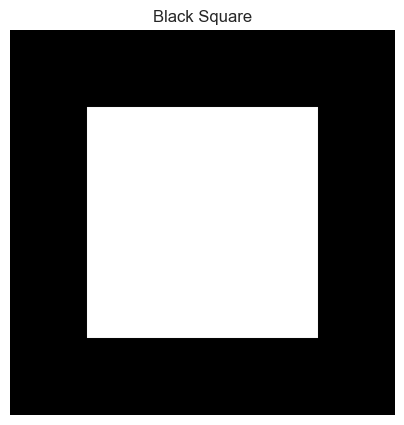

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ar = np.zeros((500, 500, 3), dtype=int)
ar[100:400, 100:400] = 255
ax.imshow(ar)
ax.set_title("Black Square")
_ = ax.axis("off")

This is a simple example, but it's quite clear that the consistency is heavily dependent on the augmentation, so much so that it's not possible to utilize it as a metric for OOD detection.